In [2]:
# import all of the needed
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
import seaborn as sns
from scipy import linalg as LA

np.random.seed(0)
np.set_printoptions(precision = 3,suppress =True)
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

In [76]:
# import data
mnist = input_data.read_data_sets('../../Dataset/MNIST/',one_hot=True)
train_data, train_label, test_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# Show some details and vis some of them
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_label.shape)
print(train_label.min(),train_label.max())
print(test_data.shape)
print(test_data.min(),test_data.max())
print(test_label.shape)
print(test_label.min(),test_label.max())
print('-----------------------')

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
(55000, 784)
0.0 1.0
(55000, 10)
0.0 1.0
(10000, 784)
0.0 1.0
(10000, 10)
0.0 1.0
-----------------------


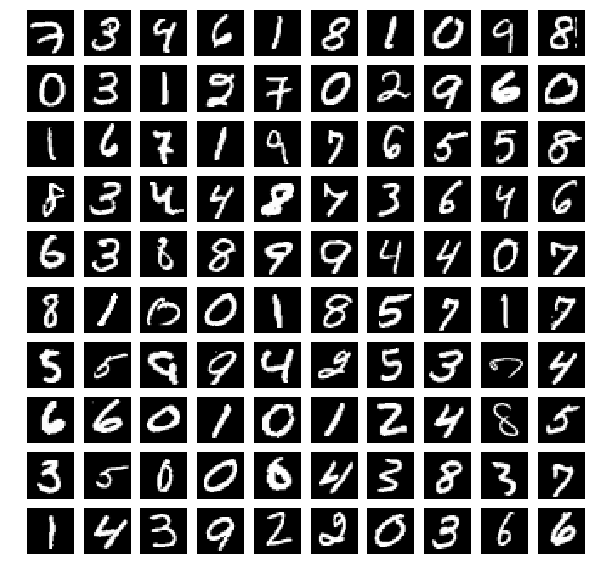

In [77]:
# view the data
def view_images(data,row=10,col=10,color=False):
    fig=plt.figure(figsize=(10, 10))
    columns = col;    rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if color:plt.imshow(data[i-1])
        else:    plt.imshow(data[i-1],cmap='gray')
        plt.grid(False)
        plt.axis('off')
    plt.show()
view_images(train_data.reshape((55000,28,28)))

In [82]:
# Define layers and the activation functions
def tf_elu(x):    return tf.nn.elu(x)
def d_tf_elu(x):  return tf.cast(tf.greater_equal(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x):   return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x):   return x
def d_tf_iden(x): return x

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x):    return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x):   return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN_Stacked_Denoising():
    # From: Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion

    def __init__(self,inc,outc,act=tf_sigmoid,d_act=d_tf_sigmoid,special_init=True,which_reg=0.0):
        if special_init:
            interval = 1/np.sqrt(inc)
            self.w   = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))

        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg      = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input  = input
        self.layer  = tf.matmul(input,self.w) 
        self.layerA = self.act(self.layer)
        return self.layerA
    
    def feedforward_inverse(self,input):
        self.input_inv = input
        self.layer_inv = tf.matmul(input,tf.transpose(self.w))
        self.layerA_inv= self.act(self.layer_inv)
        return self.layerA_inv

    def backprop(self,gradient=None,which_reg=0):
        
        grad_part1_inv = gradient
        grad_part2_inv = self.d_act(self.layer_inv)
        grad_part3_inv = self.input_inv
        grad_pass_inv  = grad_part1_inv * grad_part2_inv
        grad_inv       = tf.transpose(tf.transpose(grad_part3_inv) @ grad_pass_inv)
        
        grad_part1     = grad_pass_inv @ self.w
        grad_part2     = self.d_act(self.layer)
        grad_part3     = self.input
        grad_          = tf.transpose(grad_part3) @ (grad_part1 * grad_part2)
        
        grad           = (grad_inv + grad_)/batch_size

        # === Reg ===
        if self.which_reg == 0.5:    grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:      grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5:    grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:      grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5:    grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:      grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:      grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        # Update the Weight First
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        return update_w

In [83]:
# hyper parameters as well as the stuffs
num_epoch = 100; learning_rate  = 0.0008 ; batch_size = 100
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = FNN_Stacked_Denoising(28*28,20*20)
l2 = FNN_Stacked_Denoising(20*20,12*12)
l3 = FNN_Stacked_Denoising(12*12,10*10)

In [84]:
# create the place holder and go 
x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)

layer1_input = x + tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=0.5, dtype=tf.float32) 
layer1     = l1.feedforward(x)
layer1_inv = l1.feedforward_inverse(layer1)
layer1_cost= tf.reduce_mean(tf.square(layer1_inv-x))
layer1_back= l1.backprop((layer1_inv-x)/batch_size)

layer2     = l2.feedforward(layer1)
layer2_inv = l2.feedforward_inverse(layer2)
layer2_cost= tf.reduce_mean(tf.square(layer2_inv-layer1))
layer2_back= l2.backprop((layer2_inv-layer1)/batch_size)

layer3     = l3.feedforward(layer2)
layer3_inv = l3.feedforward_inverse(layer3)
layer3_cost= tf.reduce_mean(tf.square(layer3_inv-layer2))
layer3_back= l3.backprop((layer3_inv-layer2)/batch_size)

In [85]:
# start the tf session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start training the first layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:]
        sess_result  = sess.run([layer1_cost,layer1_back],feed_dict={x:current_data})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

Iter: 99 cost: 0.0026971565

In [86]:
# start training the second layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:]
        sess_result  = sess.run([layer2_cost,layer2_back],feed_dict={x:current_data})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

Iter: 99 cost: 0.0151497955

In [87]:
# start training the thrid layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:]
        sess_result  = sess.run([layer3_cost,layer3_back],feed_dict={x:current_data})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

Iter: 99 cost: 0.0174728975

In [88]:
# get the layers
weight_layer1 = sess.run(l1.getw()); weight_layer2 = sess.run(l2.getw()); weight_layer3 = sess.run(l3.getw())
print(weight_layer1.shape)
print(weight_layer2.shape)
print(weight_layer3.shape)

(784, 400)
(400, 144)
(144, 100)


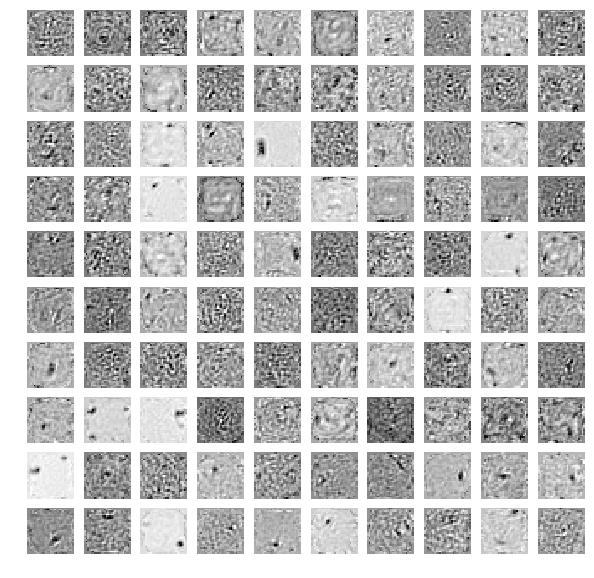

In [89]:
view_images(weight_layer1.T.reshape((400,28,28)))

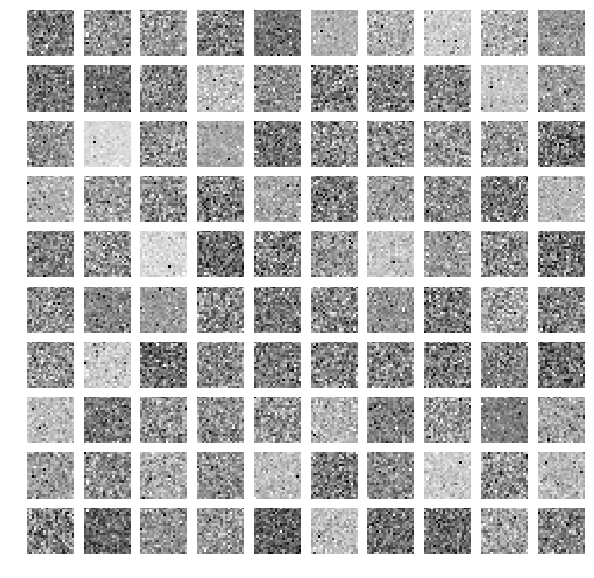

In [90]:
view_images(weight_layer2.T.reshape((144,20,20)))

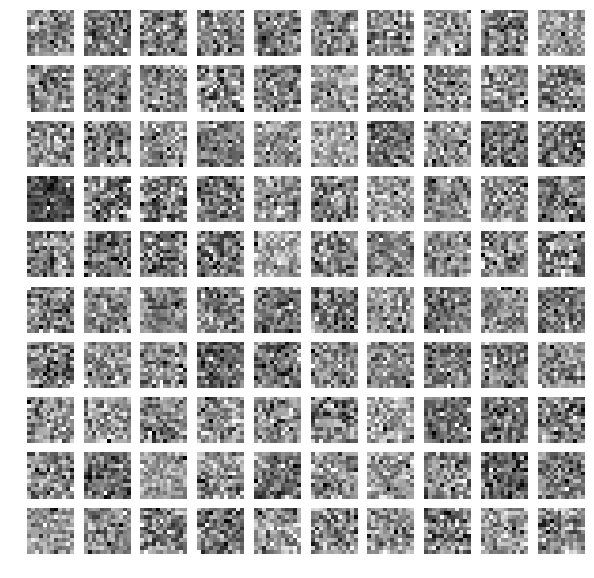

In [91]:
view_images(weight_layer3.T.reshape((100,12,12)))

# Reference
1. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
2. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
3. 